In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.Container {width:85% !important;}
div.CodeMirror {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.output_area pre {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.output_wrapper pre {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.input {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
</style>
"""))

# 딥러닝을 사용한 경기결과 예측
- 모델 두가지를 사용하여 정확도 및 결과 확인
- 선수 별이 아닌 팀 별 데이터가 필요

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential # 3. 모델 생성
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

## 다중분류

In [3]:
# ▶ 1. 데이터 셋 준비
df = pd.read_csv('D:/Gray_Bigdata/src/00_Projects/data/game_result/england-premier-league-matches-2020-to-2021-stats.csv')

In [4]:
df

,result,date,home_team_name,away_team_name,referee,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,...,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no
0,L,Sep 12 2020 - 11:30am,Fulham,Arsenal,Chris Kavanagh,0.53,1.74,0,3,3,...,0.00,6.00,4.55,1.53,1.24,1.74,2.90,5.40,1.80,1.87
1,W,Sep 12 2020 - 2:00pm,Crystal Palace,Southampton,Jonathan Moss,1.21,0.84,1,0,1,...,0.00,3.20,3.30,2.50,1.38,2.15,4.00,8.00,1.83,1.83
2,W,Sep 12 2020 - 4:30pm,Liverpool,Leeds United,Michael Oliver,1.74,1.58,4,3,7,...,0.00,1.33,6.10,8.75,1.16,1.53,2.35,4.05,1.80,1.87
3,L,Sep 12 2020 - 7:00pm,West Ham United,Newcastle United,Stuart Attwell,1.79,1.16,0,2,2,...,0.00,1.91,3.85,4.35,1.27,1.87,3.20,6.10,1.71,1.95
4,L,Sep 13 2020 - 1:00pm,West Bromwich Albion,Leicester City,Anthony Taylor,0.79,2.00,0,3,3,...,0.00,3.85,3.65,1.95,1.30,1.95,3.40,6.55,1.77,1.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,W,May 23 2021 - 3:00pm,Liverpool,Crystal Palace,Craig Pawson,1.74,1.11,2,0,2,...,2.67,1.20,6.50,13.00,1.11,1.36,1.98,3.05,1.95,1.74
376,W,May 23 2021 - 3:00pm,Manchester City,Everton,Michael Oliver,2.16,1.95,5,0,5,...,3.00,1.33,5.25,8.00,1.19,1.61,2.68,4.05,1.74,1.95
377,W,May 23 2021 - 3:00pm,Sheffield United,Burnley,Kevin Friend,0.84,1.11,1,0,1,...,3.00,2.88,3.30,2.50,1.35,1.88,2.75,4.90,1.62,2.15
378,W,May 23 2021 - 3:00pm,West Ham United,Southampton,Martin Atkinson,1.79,0.84,3,0,3,...,3.11,1.70,3.80,5.00,1.22,1.76,3.25,4.45,1.62,2.15


In [5]:
df.columns

Index(['result', 'date', 'home_team_name', 'away_team_name', 'referee',
       'home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
       'total_goal_count', 'total_goals_at_half_time',
       'home_team_goal_count_half_time', 'away_team_goal_count_half_time',
       'home_team_corner_count', 'away_team_corner_count',
       'home_team_yellow_cards', 'home_team_red_cards',
       'away_team_yellow_cards', 'away_team_red_cards',
       'home_team_first_half_cards', 'home_team_second_half_cards',
       'away_team_first_half_cards', 'away_team_second_half_cards',
       'home_team_shots', 'away_team_shots', 'home_team_shots_on_target',
       'away_team_shots_on_target', 'home_team_shots_off_target',
       'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls',
       'home_team_possession', 'away_team_possession', 'team_a_xg',
       'team_b_xg', 'average_goals_per_match_pre_match',
       'btts_percentage_pre_match', 'over_15_percentage_pre_match',
    

In [6]:
df.drop(columns=['date', 'home_team_name', 'away_team_name', 'referee', 'home_ppg', 'away_ppg',
                 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count',
                 'over_25_percentage_pre_match',
                 'over_35_percentage_pre_match', 'over_45_percentage_pre_match',
                 'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match',
                 'over_15_2HG_percentage_pre_match', 'over_05_2HG_percentage_pre_match',
                 'average_corners_per_match_pre_match', 'average_cards_per_match_pre_match'], inplace=True)

In [175]:
# df.rename(columns={'home_team_goal_count' : 'HGoalCnt', 'away_team_goal_count' : 'AGoalCnt',
#                    'total_goal_count' : 'TgoalCnt'}, inplace=True)

In [7]:
gameResult_x = df.iloc[:, 1:].to_numpy()
gameResult_y = df.iloc[:, 0]

print('타겟변수y가 될 경기결과의 종류 :', gameResult_y.unique())

타겟변수가 될 경기결과의 종류 : ['L' 'W' 'D']


In [8]:
# ▶ 2. 데이터 전처리
# 입력(독립)변수 라벨 인코딩
scaler = MinMaxScaler()
scaler.fit(gameResult_x)
gameResult_x = scaler.transform(gameResult_x)

# # 결과(타겟)변수 원-핫 인코딩(라벨링 전환) 후 numpy 배열로 변환
gameResult_y = pd.get_dummies(gameResult_y).to_numpy()

gameResult_y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [9]:
# 훈련셋과 검증셋 나누기
train_X, test_X, train_Y, test_Y = train_test_split(gameResult_x, gameResult_y, test_size = 0.3, 
                                                    random_state = 1)

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(266, 37) (266, 3) (114, 37) (114, 3)


In [10]:
# ▶ 3. 모델 구성
model = Sequential()
model.add(Input(37)) # input_dim만 지정되어 있는 레이어

model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(units = 30, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))


# ▶ 4. 모델 학습과정 설정
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])


# ▶ 5. 모델 학습
earlyStopping = EarlyStopping(patience = 20, monitor = 'val_loss')
hist = model.fit(train_X, train_Y, epochs = 300, batch_size = 200,
                 verbose = 1, callbacks = [earlyStopping], validation_split = 0.2)

Epoch 1/300
2/2 [==============================] - 1s 225ms/step - loss: 1.0915 - accuracy: 0.4340 - val_loss: 1.0985 - val_accuracy: 0.2778
Epoch 2/300
2/2 [==============================] - 0s 18ms/step - loss: 1.0764 - accuracy: 0.4057 - val_loss: 1.0987 - val_accuracy: 0.2778
Epoch 3/300
2/2 [==============================] - 0s 19ms/step - loss: 1.0714 - accuracy: 0.4340 - val_loss: 1.1002 - val_accuracy: 0.2778
Epoch 4/300
2/2 [==============================] - 0s 19ms/step - loss: 1.0615 - accuracy: 0.4151 - val_loss: 1.1009 - val_accuracy: 0.2593
Epoch 5/300
2/2 [==============================] - 0s 18ms/step - loss: 1.0557 - accuracy: 0.4151 - val_loss: 1.1006 - val_accuracy: 0.2963
Epoch 6/300
2/2 [==============================] - 0s 18ms/step - loss: 1.0504 - accuracy: 0.4198 - val_loss: 1.1010 - val_accuracy: 0.2963
Epoch 7/300
2/2 [==============================] - 0s 19ms/step - loss: 1.0456 - accuracy: 0.4198 - val_loss: 1.1016 - val_accuracy: 0.2963
Epoch 8/300
2/2 [==

2/2 [==============================] - 0s 17ms/step - loss: 0.7559 - accuracy: 0.6840 - val_loss: 0.8945 - val_accuracy: 0.6111
Epoch 59/300
2/2 [==============================] - 0s 19ms/step - loss: 0.7543 - accuracy: 0.6887 - val_loss: 0.8851 - val_accuracy: 0.6296
Epoch 60/300
2/2 [==============================] - 0s 17ms/step - loss: 0.7509 - accuracy: 0.6981 - val_loss: 0.8546 - val_accuracy: 0.6667
Epoch 61/300
2/2 [==============================] - 0s 19ms/step - loss: 0.7383 - accuracy: 0.7123 - val_loss: 0.8264 - val_accuracy: 0.6296
Epoch 62/300
2/2 [==============================] - 0s 19ms/step - loss: 0.7322 - accuracy: 0.7170 - val_loss: 0.8136 - val_accuracy: 0.5926
Epoch 63/300
2/2 [==============================] - 0s 17ms/step - loss: 0.7292 - accuracy: 0.7170 - val_loss: 0.8092 - val_accuracy: 0.5741
Epoch 64/300
2/2 [==============================] - 0s 17ms/step - loss: 0.7487 - accuracy: 0.6934 - val_loss: 0.8113 - val_accuracy: 0.5926
Epoch 65/300
2/2 [========

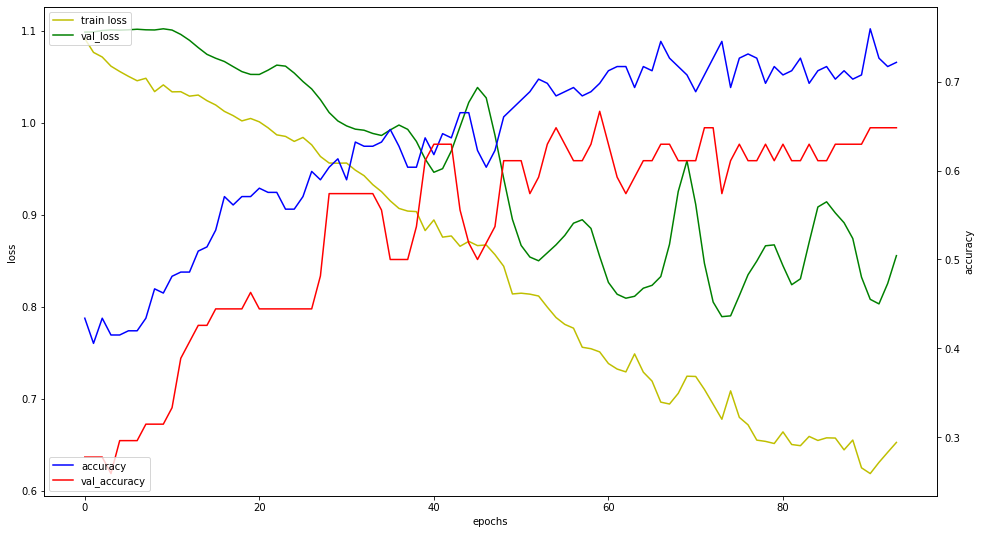

In [11]:
# ▶ 6. 모델 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize = (16, 9))

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label = 'val_loss')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label = 'accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'r', label = 'val_accuracy')

acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 'lower left')

plt.show()

In [12]:
# ▶ 7. 모델 평가 및 성능지표
loss_and_acc = model.evaluate(test_X, test_Y)

print('Loss :', round(loss_and_acc[0]*100, 2), '%')
print('Accuracy :', round(loss_and_acc[1]*100, 2), '%')

4/4 [==============================] - 0s 998us/step - loss: 0.7400 - accuracy: 0.7193
Loss : 74.0 %
Accuracy : 71.93 %


In [14]:
# 성능 지표 (crosstab)
pred = model.predict(test_X).argmax(axis = 1)
# pred = np.argmax(model.predict(test_X), axis = 1)+3

# real = test_Y.armax(axis = 1)+3
real = np.argmax(test_Y, axis = 1)

cross_tab = pd.crosstab(real, pred)
cross_tab.index.name = 'real'
cross_tab.columns.name = 'predict'

cross_tab

predict,0,1,2
real,,,
0,3,10,7
1,0,47,5
2,4,6,32


## 인공신경망(ANN)